In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
from torch.backends import cudnn
cudnn.enabled = True
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim, nn
import cityscapesscripts.helpers.labels as labels
from ignite.metrics import MultiLabelConfusionMatrix, Loss
from cityscapesscripts.helpers.labels import trainId2label

from torchvision import transforms

import cityscapes.dataloader
from tqdm import tqdm
from net.resnet50_cam import Net
import typing

import numpy as np
import matplotlib.pyplot as plt

from step.train_cam_grid import thresholded_output_transform, get_cityscapes_dataloders

import wandb

In [3]:
wandb.init(project="irn-patch", job_type="inspect")

wandb: Currently logged in as: wow056 (postech-cv). Use `wandb login --relogin` to force relogin


In [5]:
wandb.restore('sess/res50_cam.pth.pth', 'postech-cv/irn-patch/hf192mzo')

<_io.TextIOWrapper name='/home/postech2/irn/wandb/run-20230223_211046-jfnt9scc/files/sess/res50_cam.pth.pth' mode='r' encoding='UTF-8'>

In [4]:
device = torch.device("cuda")
model = Net()
model.load_state_dict(torch.load("/home/postech2/irn/wandb/run-20230223_211046-jfnt9scc/files/sess/res50_cam.pth.pth"))
model.to(device)

Net(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FixedBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [7]:
_, val_dl = get_cityscapes_dataloders(64, 256, 8, 128)
cm = MultiLabelConfusionMatrix(20, device=device)

with torch.no_grad():
    for (img, hot_label, unique_label) in tqdm(val_dl, desc="validating"):
        img = img.cuda(non_blocking=True)
        unique_label = unique_label.to(dtype=torch.long).cuda(non_blocking=True)
        hot_label = hot_label.cuda(non_blocking=True)

        pred = model(img)

        thresholded = thresholded_output_transform((pred, hot_label))
        thresholded_pred, thresholded_label = thresholded

        cm.update(thresholded)

validating: 100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]


/home/postech2/venv/irn/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


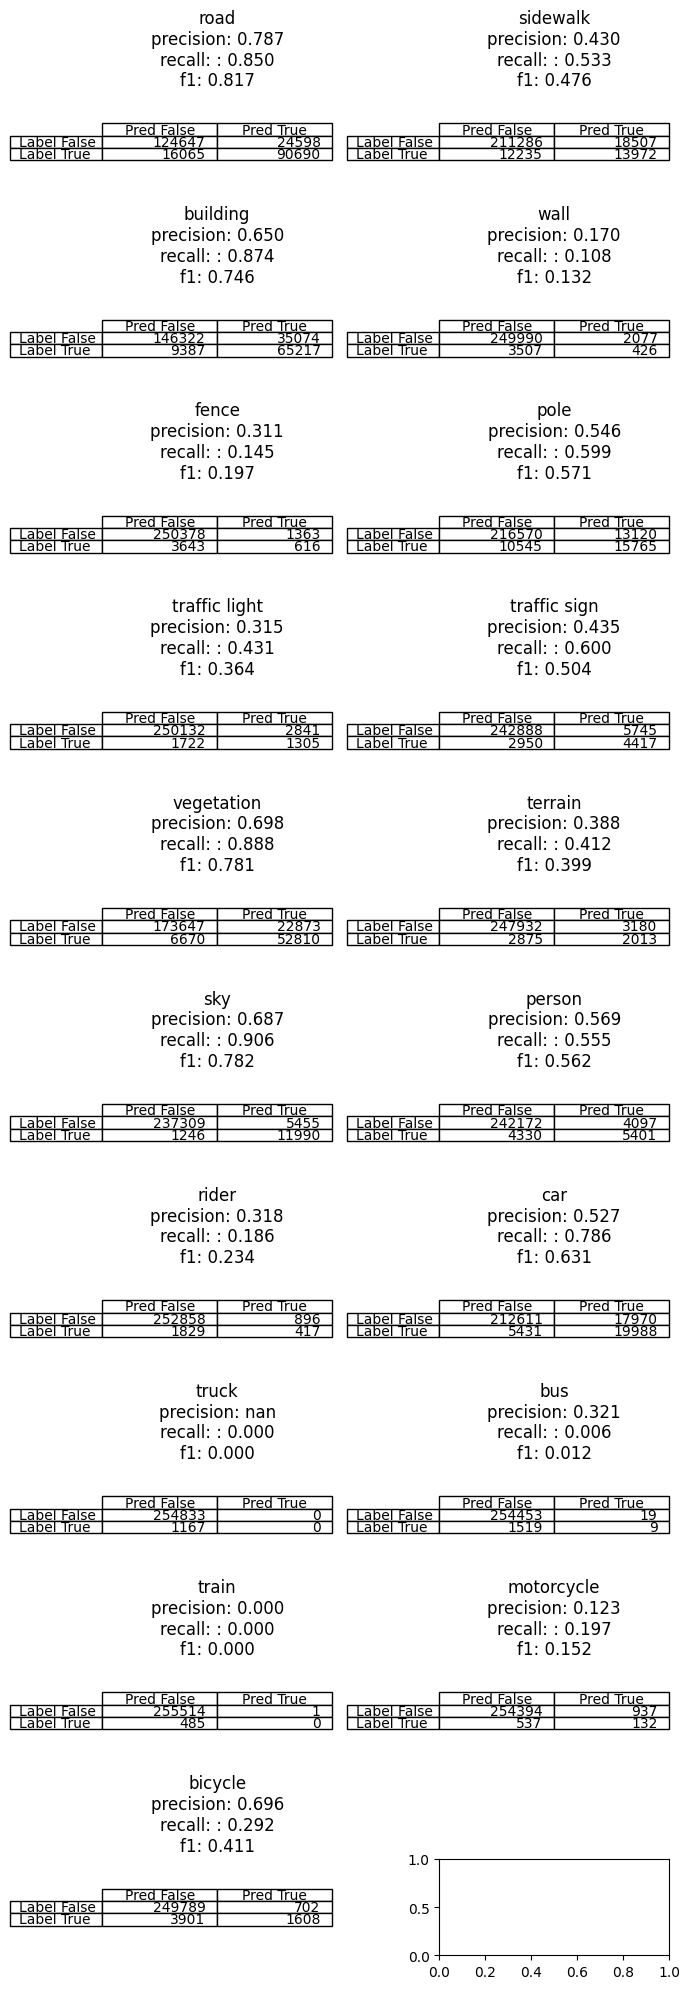

In [16]:
import seaborn as sn
import pandas as pd
result = cm.compute()
result.shape
fig, axs = plt.subplots(10, 2, figsize=(3.5 * 2, 2 * 10))
for i in range(10):
    for j in range(2):
        if i * 2 + j < 19:
            subarr = result[i * 2 + j].cpu().numpy()
            arg = subarr.argmax()
            precision = subarr[1, 1] / (subarr[1, 1] + subarr[0, 1])
            recall = subarr[1, 1] / (subarr[1, 1] + subarr[1, 0])
            f1 = 2 * subarr[1, 1] / (2 * subarr[1, 1] + subarr[0, 1] + subarr[1, 0])
            
            if arg == 0:
                annotation = "true negative"
            elif arg == 1:
                annotation = "false positive"
            elif arg == 2:
                annotation = "false negative"
            elif arg == 3:
                annotation = "true positive"
            
            ax = axs[i, j]
            ax.axis('off')
            ax.set_title(trainId2label[i * 2 + j].name+f"\nprecision: {precision:.3f}\nrecall: : {recall:.3f}\nf1: {f1:.3f}")
            ax.table(
                subarr, 
                loc='center',
                rowLabels=['Label False', 'Label True'],
                colLabels=['Pred False', 'Pred True']
            )
plt.tight_layout()
plt.show()

vegetation, sky


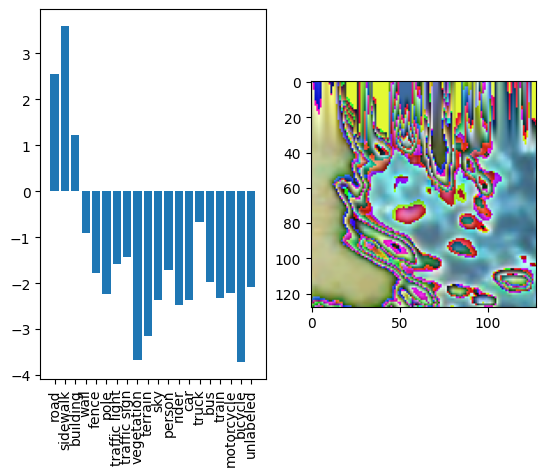

In [54]:
image, hot_label, unique_label = ds[22]
result = model(image.unsqueeze(0).to(device=device))

labels = [trainId2label[key].name for key in sorted(trainId2label.keys()) if key >=0]
x = np.arange(len(labels))

values = result.detach().cpu().numpy().squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2)

print(", ".join((trainId2label[p.item()].name for p in hot_label.nonzero()[0] if p.item() < 19)))

ax1.bar(x, values)
ax1.set_xticks(x, labels, rotation=90)

ax2.imshow(transforms.ToPILImage()(image))
plt.show()

In [58]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt


def load_arr(divide_size):
    return np.array([np.load(filename) for filename in glob.glob(f'/home/postech2/datasets/cityscapes/gtFine/train/**/*_labelTrainIds_divide_{divide_size}_slots_19.npy')])
def class_hist(divide_size):
    l = load_arr(divide_size)
    l = l.reshape((-1, l.shape[-1]))
    nz = np.count_nonzero(l, axis=1)
    hist, bin_edges = np.histogram(nz, bins='auto', density=True)
    return hist, bin_edges

def nonzeros(divide_size):
    l = load_arr(divide_size)
    l = l.reshape((-1, l.shape[-1]))
    nz = np.count_nonzero(l, axis=1)
    return np.bincount(nz).astype(np.float32) / l.shape[0]

In [59]:
l = load_arr(16)
l = l.reshape((-1, l.shape[-1]))
l.shape

(24371200, 19)

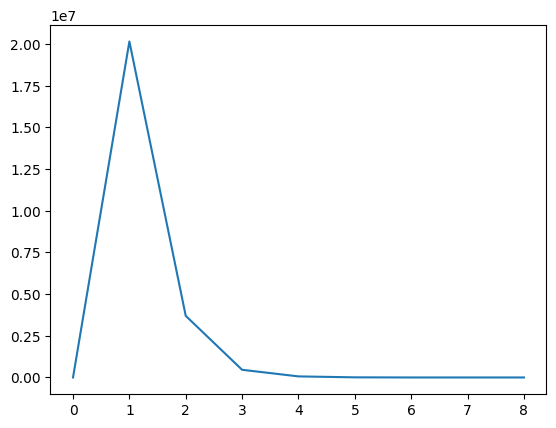

In [60]:
nonzero_plot(16)

In [43]:
print(load_arr(16).shape)
print(load_arr(32).shape)
print(load_arr(64).shape)

(2975, 64, 128, 19)
(2975, 32, 64, 19)
(2975, 16, 32, 19)


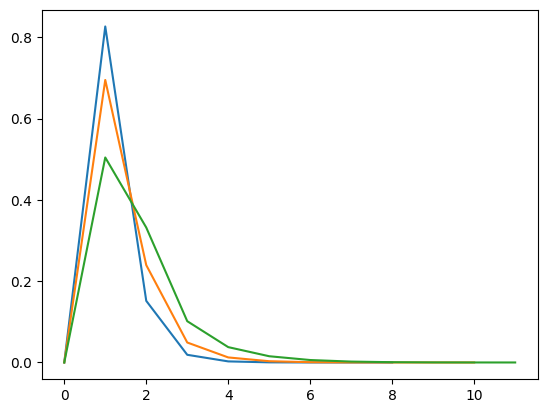

In [65]:
import matplotlib.pyplot as plt

for ds in [16, 32, 64]:
    plt.plot(nonzeros(ds))
plt.show()

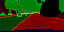

In [68]:

Image.fromarray(np.packbits(arr, axis=2))

(32, 32, 3)


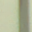

In [79]:
arr_img = np.load("/home/postech2/datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit_divide_32.npy")
print(arr_img[0, 0].shape)
Image.fromarray(arr_img[0, 0].astype(np.uint8))

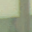

In [80]:

Image.fromarray(arr_img[1, 0].astype(np.uint8))

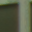

In [81]:

Image.fromarray(arr_img[2, 0].astype(np.uint8))

In [ ]:
arr = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_000032_2_0_1_img.npy")
label = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_000032_2_0_1_label.npy")
print(cats[label.nonzero()])
Image.fromarray(arr)

In [ ]:
arr = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_000032_2_1_0_img.npy")
label = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_000032_2_1_0_label.npy")
print(cats[label.nonzero()])
Image.fromarray(arr)

In [ ]:
arr = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_000032_2_1_1_img.npy")
label = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_000032_2_1_1_label.npy")
print(cats[label.nonzero()])
Image.fromarray(arr)

In [ ]:
arr = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_001487_2_0_1_img.npy")
label = np.load("/home/postech2/irn/VOCdevkit/VOC2012/Divided/2007_001487_2_0_1_label.npy")
print(cats[label.nonzero()])
Image.fromarray(arr)

In [21]:
from cityscapes.dataloader import CityScapesDividedDataset, Divide
from torch.utils.data import DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
ds = CityScapesDividedDataset(Divide.Train, 2048, 1024, 128)
dl = DataLoader(ds, batch_size=1024, num_workers=16)

In [22]:
from cityscapesScripts.cityscapesscripts.helpers.labels import trainId2label
mapper = np.zeros((19, ), dtype=object)
for trainId, label in trainId2label.items():
    if trainId == 255 or trainId == -1:
        trainId = 18
    print(label.name)
    mapper[trainId] = label.name
mapper

license plate
bicycle
motorcycle
train
unlabeled
bus
truck
car
rider
person
sky
terrain
vegetation
traffic sign
traffic light
pole
fence
wall
building
sidewalk
road


array(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'unlabeled'], dtype=object)

['building']


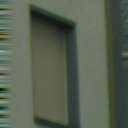

In [23]:

a, b, c = ds[0]
b = b.nonzero()[0]

print(mapper[b[b<19]])
Image.fromarray(a)

['road' 'sidewalk' 'fence' 'terrain']


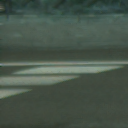

In [24]:

a, b, c = ds[64]
b = b.nonzero()[0]

print(mapper[b[b<19]])
Image.fromarray(a)